# RESULT ANALYSIS FOR MODEL

IMPORT REQUIRED LIBRARY

In [126]:
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.tree import export_text
import sys
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib

# Add the path to the src directory to the path
notebooks_path = os.path.dirname(os.getcwd())
ml_puppils_path = os.path.dirname(notebooks_path)
src_path = os.path.join(ml_puppils_path, 'src')
sys.path.append(src_path)
import utils.utils as utils
import utils.testutils as testutils
import utils.dataloader as dataloader

IMG_SIZE = (256, 256)
IMAGE_COLUMNS= 4
IMAGE_ROWS = 1



DEFINE SOME SUPPORTED FUNCTIONS

In [119]:
def get_classified_items_statistic(y_true, y_pred):
    """Extract misclassified items with their predicted and true classes."""
    missclassified = [{}, {}, {}, {}]
    
    for i, (true_label, pred_label) in enumerate(zip(y_true, y_pred)):
            if pred_label not in missclassified[true_label]:
                missclassified[true_label][pred_label] = [i]
            else:
                missclassified[true_label][pred_label].append(i)
    return missclassified


In [82]:
def display_img(image_sample, classes):
    
    # Create a row of subplots with equal sizes
    fig, axes = plt.subplots(IMAGE_ROWS, IMAGE_COLUMNS, figsize=(10, 10))  

    # If only one image, axes is not iterable, so we convert it into a list
    if len(image_sample) == 1:
        axes = [axes]

    axes = axes.flatten()


    # Display images in a row
    for i, data in enumerate(image_sample):
        axes[i].imshow(data, cmap='gray')  # Show the image in grayscale
        axes[i].axis('off')  # Hide the axes
        axes[i].set_title(f"{classes[i]}")  # Title for each image

    for j in range(len(image_sample), 4):
        axes[j].axis('off')

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show() # Show the plot

In [121]:
def get_result_statistic(image_dataset, y_true, y_preds, image_on=True):
    result_statistic = get_classified_items_statistic(y_true, y_preds)
    result_statistic_dict = []
    for i in range(4):
        print(f"Statistic about class {i}")
        statistic = {}
        statistic['true_quan'] = sum(y_true == i)
        class_result = result_statistic[i]
        pnegative = 0
        for key, value in class_result.items():
            if key == i:
                statistic['true_positive'] = len(value)
                print(f"Correctly classified as class {i}: {len(value)}")
                continue
            statistic[key] = len(value)
            pnegative += len(value)
            print(f"Missed classified objects that in class {key}: {len(value)}")
            if image_on:
                value = value[:4]
                value = [image_dataset[i] for i in value]
                display_img(value, [key]*len(value))
        statistic['false_positive_quan'] = pnegative
        result_statistic_dict.append(statistic)
        print(f"Total number of items for class in real dataset: {statistic['true_quan']}")
        print(f"Number of false positive: {statistic['false_positive_quan']} ~ {statistic['false_positive_quan']/statistic['true_quan']*100}%")
        print()
    return result_statistic_dict

In [ ]:
def eval_model(model_arg, image=True):
    test_raw_path = os.path.join(src_path, 'dataset/raw/Testing')
    test_processed_path = os.path.join(src_path, 'dataset/processed/test.npz')
    saved_model = os.path.join(src_path, f'results/models/{model_arg}')
    model_path = utils.get_latest_model_path(saved_model)
    image_dataset = np.load(test_processed_path)
    try:
        model_module = importlib.import_module(f"models.{model_arg}")
    except ModuleNotFoundError:
        raise ValueError(f"Model '{model_arg}' not found. Ensure there is a corresponding file in models/.")
    
    # Dynamically load train and evaluate functions
    eval_func = getattr(model_module, "evaluate", None)
    
    dataset = dataloader.get_dataset(test_raw_path, test_processed_path)
    image_dataset, y_true = dataset.images, dataset.labels
    y, y_preds, y_scores = eval_func(dataset, model_path, model_arg)
    print(testutils.metric_results(y, y_preds, y_scores, ["full"]))
    return get_result_statistic(image_dataset, y_true, y_preds, image)

EVALUATION

Loaded saved dataset from /Users/phuocpham/Desktop/ML_assignment/ml-pupils/src/dataset/processed/test.npz
Model loaded from /Users/phuocpham/Desktop/ML_assignment/ml-pupils/src/results/models/decision_tree/decision_tree_03032025_10-37-13.pkl
-----TREE DETAILS-----
Tree Depth: 31
Total Nodes: 1033
Leaf Nodes: 517
Number of Features Used: 65536
Statistic about class 0
Correctly classified as class 0: 187
Missed classified objects that in class 3: 58


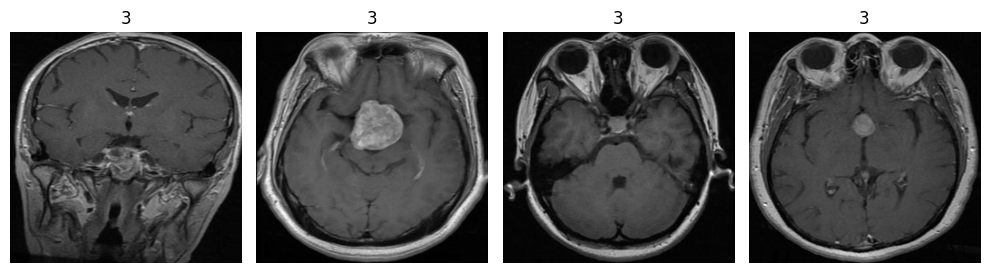

Missed classified objects that in class 1: 15


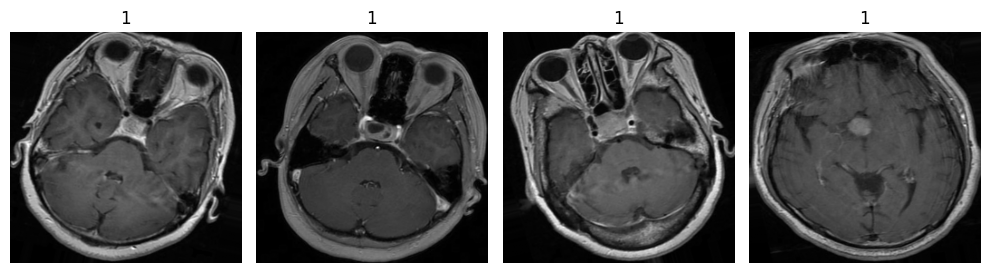

Missed classified objects that in class 2: 40


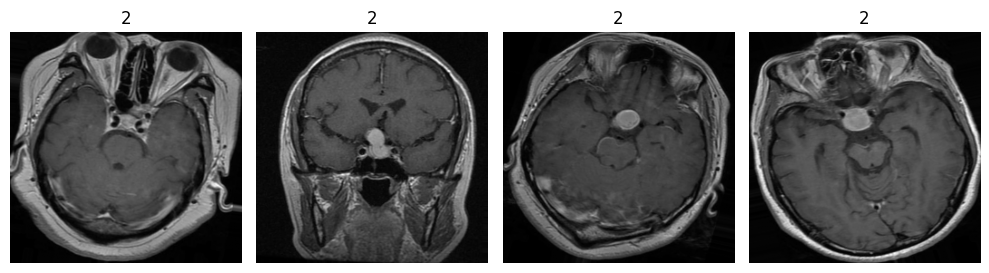

Total number of items for class in real dataset: 300
Number of false positive: 113 ~ 37.666666666666664%

Statistic about class 1
Correctly classified as class 1: 320
Missed classified objects that in class 3: 41


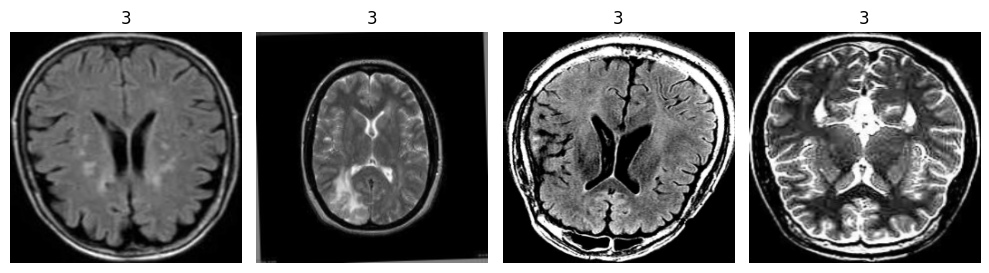

Missed classified objects that in class 0: 13


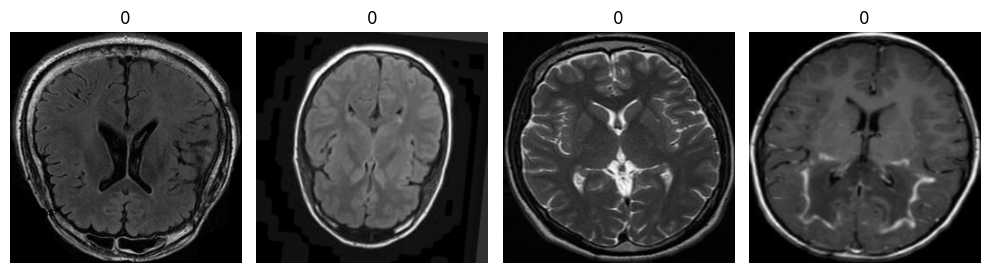

Missed classified objects that in class 2: 31


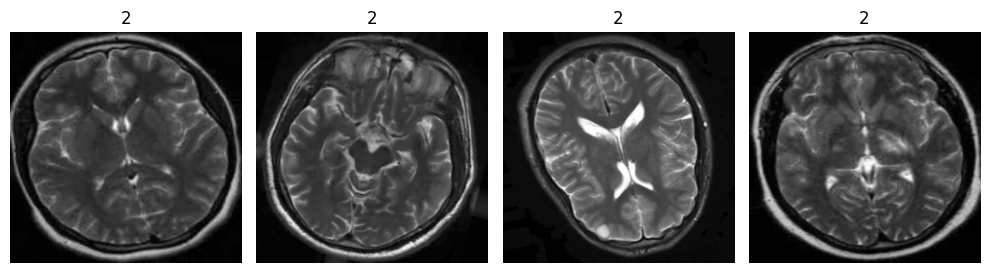

Total number of items for class in real dataset: 405
Number of false positive: 85 ~ 20.98765432098765%

Statistic about class 2
Missed classified objects that in class 3: 70


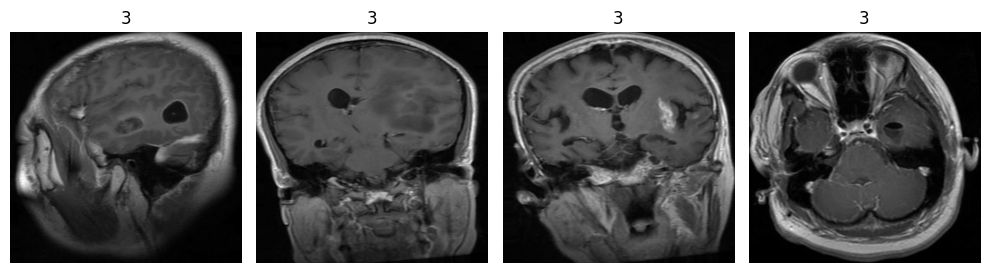

Correctly classified as class 2: 159
Missed classified objects that in class 0: 46


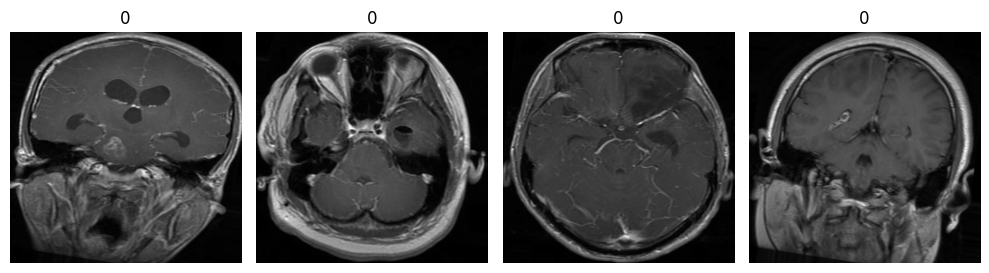

Missed classified objects that in class 1: 25


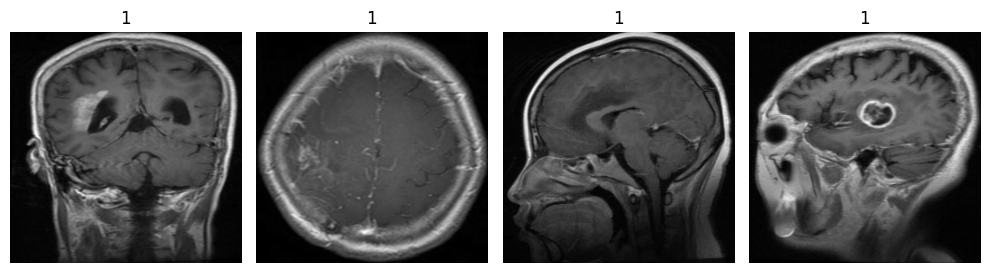

Total number of items for class in real dataset: 300
Number of false positive: 141 ~ 47.0%

Statistic about class 3
Correctly classified as class 3: 144
Missed classified objects that in class 1: 81


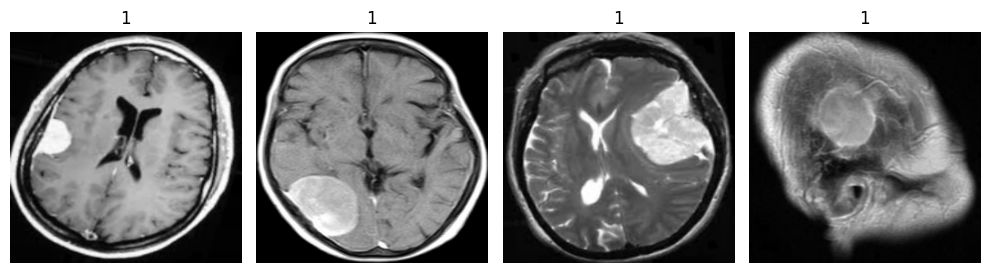

Missed classified objects that in class 0: 38


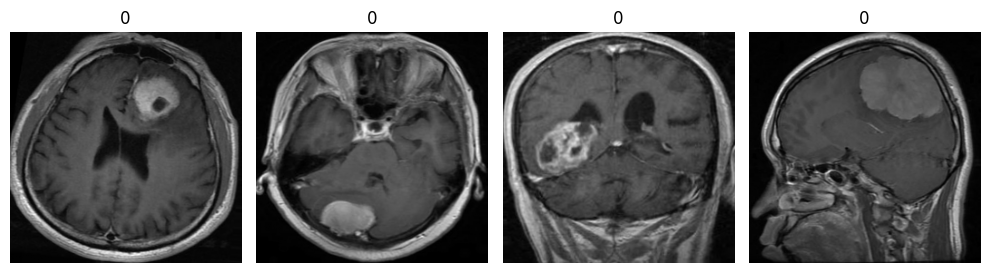

Missed classified objects that in class 2: 43


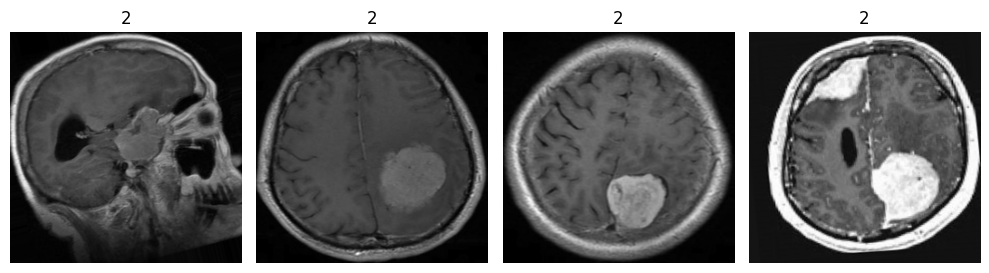

Total number of items for class in real dataset: 306
Number of false positive: 162 ~ 52.94117647058824%



In [ ]:
evaluation = eval_model('decision_tree', image=True)
